# Model performance

Tuning and determining model performance.

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

Each model we have met so far has several parameters that need tuning. So called hyper-parameters. This lecture will discuss methods for systematically searching for the best
hyper-parameters and the nassessing how well the model will perform on unseen data.


## Overfitting

A model that simply memorises all training points will obtain a perfect score on the
dataset used for training. In general it will perform poorly on new, unseen data. What
we really want is not a model that memorises but one that learns to generalise. This means
we should use a dataset that was not seens as part of the model fitting to evaluate the
performance of the model.

In the past lectures we split our data into a training and testing set, then tried different
values of a hyper-parameter and picked the one that performs best on the test dataset:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

iris = datasets.load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target,
                                                    test_size=0.4, random_state=1)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.98333333333333328

As we explore different values of `C` are we going to find a setting which does the equivalent of "memorising" the dataset? Is the score obtained on the testing dataset
a fair estimate of the classifier's performance on new, unseen data?

The answer is no.


## Three way split

We need a third set, a validation set. To get the naming right:

* our whole dataset is `X`
* we split `X` into training and testing
* we further split the testing dataset into a testing and validation set

Or we directly split `X` into training, validation, and testing. The testing dataset should be locked away into a vault. You can only use it once you have frozen all the parameters and
choices involved in your model.

One drawback of splitting things into three sets is that we reduce the number of points
available for training, testing and validation. A solution to this problem is called
cross-validation.

We still create a testing dataset that gets locked in a vault. However we split our
training dataset using cross-validation (CV). The idea is the following:

Split the training data into `k` blocks. Select one of the `k` blocks as testing data,
train your model on the other `k-1` blocks. Change `k`, and repeat. This allows you to
obtain `k` independent estimates of your models performance.

In scikit-learn you can obtain estimates using CV as follows:

In [3]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[ 1.          0.94444444  0.94444444  1.          1.        ]


In [4]:
# as you have several estimates you can also compute a measure of the spread
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.98 (+/- 0.03)


## Tune up

So far we only ever tuned one parameter at a time for a model. Most models have several
parameters that influence each other. To tune them all in one go we can perform a grid
search. We specify a grid of parameters to evaluate and for each point we perform CV:

In [5]:
from sklearn.model_selection import GridSearchCV


parameter_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                   'C': [1, 10, 100, 1000]},
                  {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVC(C=1), parameter_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [6]:
# best parameters
print(clf.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [7]:
# test scores for the whole grid
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

0.611 (+/-0.066) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.411 (+/-0.141) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.911 (+/-0.058) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.611 (+/-0.066) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.978 (+/-0.027) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.911 (+/-0.058) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.967 (+/-0.028) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.978 (+/-0.027) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.978 (+/-0.027) for {'C': 1, 'kernel': 'linear'}
0.956 (+/-0.043) for {'C': 10, 'kernel': 'linear'}
0.922 (+/-0.048) for {'C': 100, 'kernel': 'linear'}
0.878 (+/-0.067) for {'C': 1000, 'kernel': 'linear'}


In [8]:
# score on the dataset we had in our vault
clf.score(X_test, y_test)

0.98333333333333328

## Random tune up

Exhaustive grid searches can be very expensive. In particular when one (or more) of the
dimensions are irrelevant to the problem. In this case it is better to perform a random
search for the best hyper-parameters.

In [9]:
from sklearn.model_selection import RandomizedSearchCV

import scipy

param_dist = {'C': scipy.stats.expon(scale=100),
              'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf', 'linear']}

# n_iter controls how many points will be sampled
clf = RandomizedSearchCV(svm.SVC(), param_dist, cv=5, n_iter=12)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=12, n_jobs=1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c2266e7f0>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7c2266e978>, 'kernel': ['rbf', 'linear']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [10]:
# best parameters
print(clf.best_params_)

{'C': 31.170679790861922, 'gamma': 0.061018182525977162, 'kernel': 'rbf'}


In [11]:
# test scores for all points that were evaluated
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

0.933 (+/-0.057) for {'C': 16.733313668628856, 'gamma': 0.0080219744208385926, 'kernel': 'linear'}
0.944 (+/-0.037) for {'C': 71.695510389892974, 'gamma': 0.062412134699136285, 'kernel': 'rbf'}
0.911 (+/-0.048) for {'C': 114.96832291142347, 'gamma': 0.24852908084885708, 'kernel': 'linear'}
0.922 (+/-0.048) for {'C': 57.422819086784095, 'gamma': 0.13924854616479118, 'kernel': 'rbf'}
0.922 (+/-0.048) for {'C': 56.81338827615776, 'gamma': 0.00098052645433355516, 'kernel': 'linear'}
0.967 (+/-0.028) for {'C': 31.170679790861922, 'gamma': 0.061018182525977162, 'kernel': 'rbf'}
0.967 (+/-0.028) for {'C': 75.51545317056069, 'gamma': 0.019282370473542892, 'kernel': 'rbf'}
0.922 (+/-0.048) for {'C': 68.184371055698875, 'gamma': 0.023863556449358402, 'kernel': 'linear'}
0.900 (+/-0.069) for {'C': 516.55222193659688, 'gamma': 0.064826475514672924, 'kernel': 'linear'}
0.911 (+/-0.048) for {'C': 144.32317406976409, 'gamma': 0.01148972860855769, 'kernel': 'linear'}
0.922 (+/-0.048) for {'C': 45.1149

### Why is random better?

For illustration purposes let's use a function which has two parameters `X1` and `X2`. However the output only depends on one of them: `X1`.

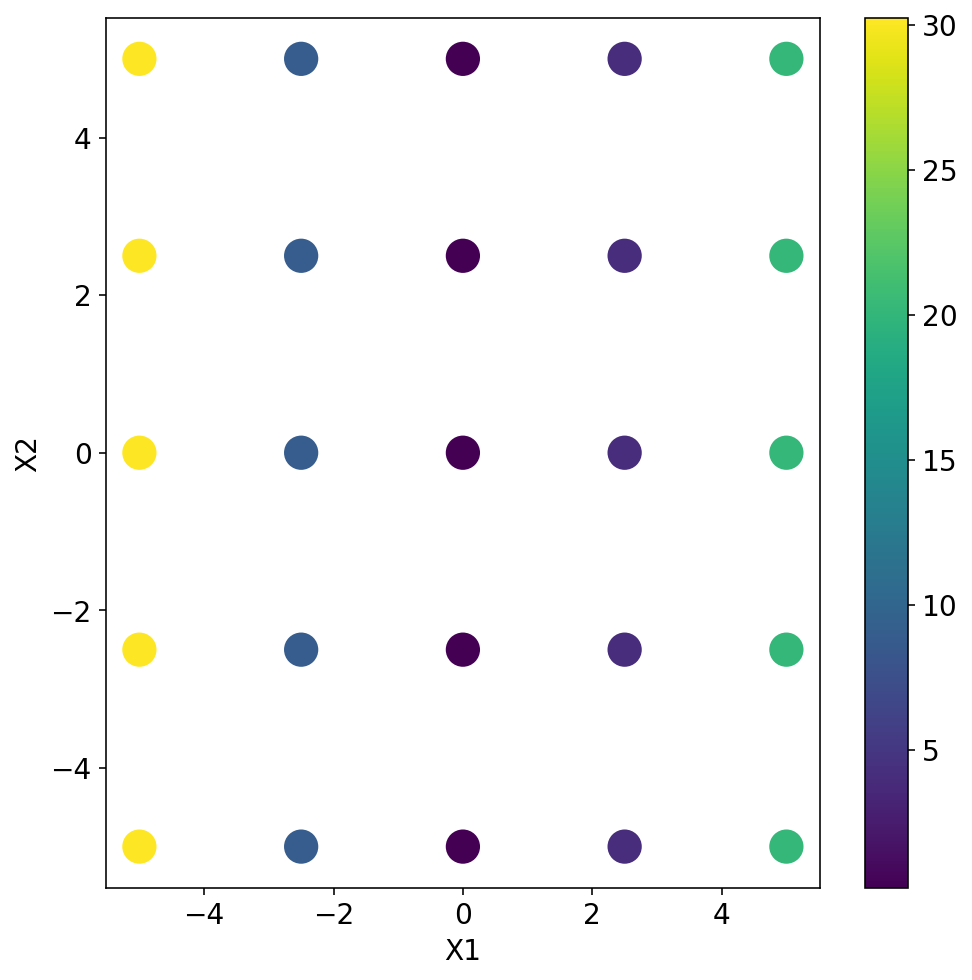

In [12]:
def f(x):
    return (0.5-x[0])**2

X1 = np.linspace(-5, 5, 5)
X2 = np.linspace(-5, 5, 5)

param_grid = []
for x1 in X1:
    for x2 in X2:
        param_grid.append((x1, x2))
param_grid = np.array(param_grid)

plt.scatter(param_grid[:, 0], param_grid[:, 1], c=[f(x) for x in param_grid], s=260)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");

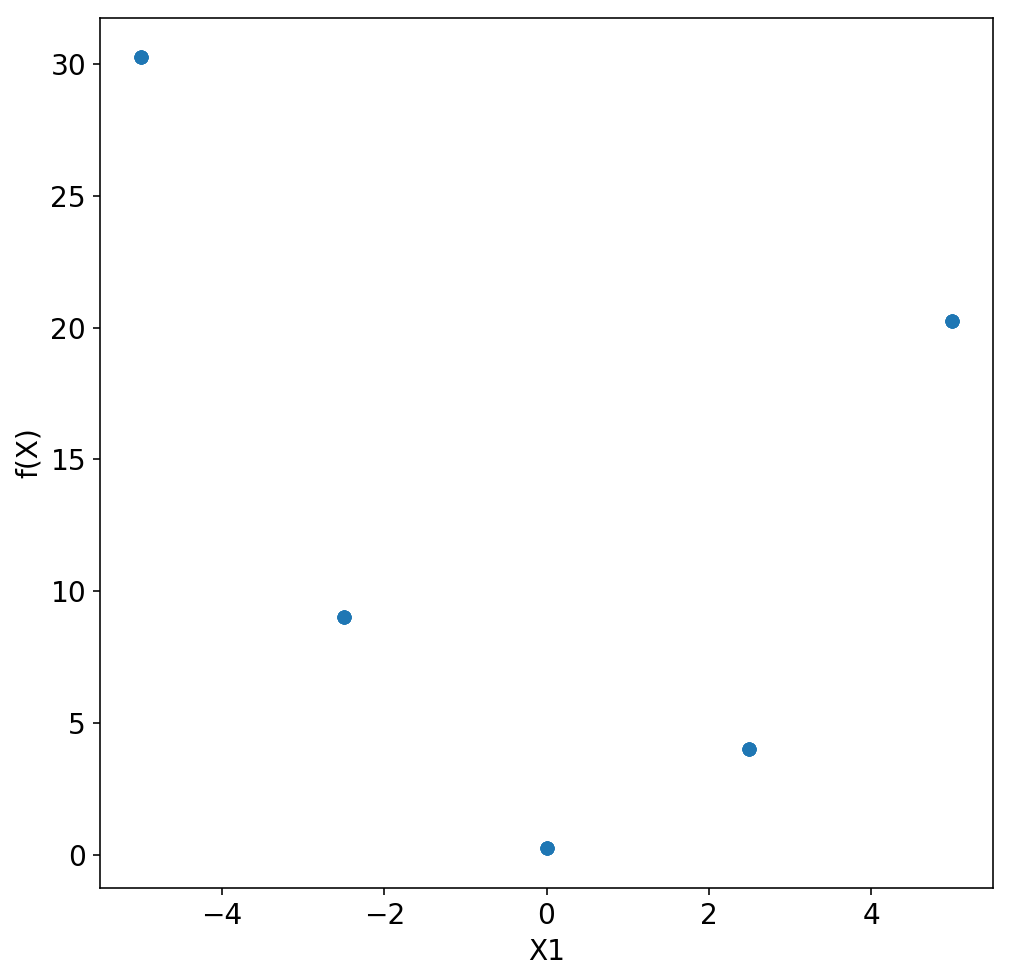

In [13]:
vals = []
for x1 in X1:
    for x2 in X2:
        vals.append((x1, x2, f((x1, x2))))
vals = np.array(vals)
        
plt.plot(vals[:, 0], vals[:, 2], 'o')
plt.xlabel("X1")
plt.ylabel("f(X)");

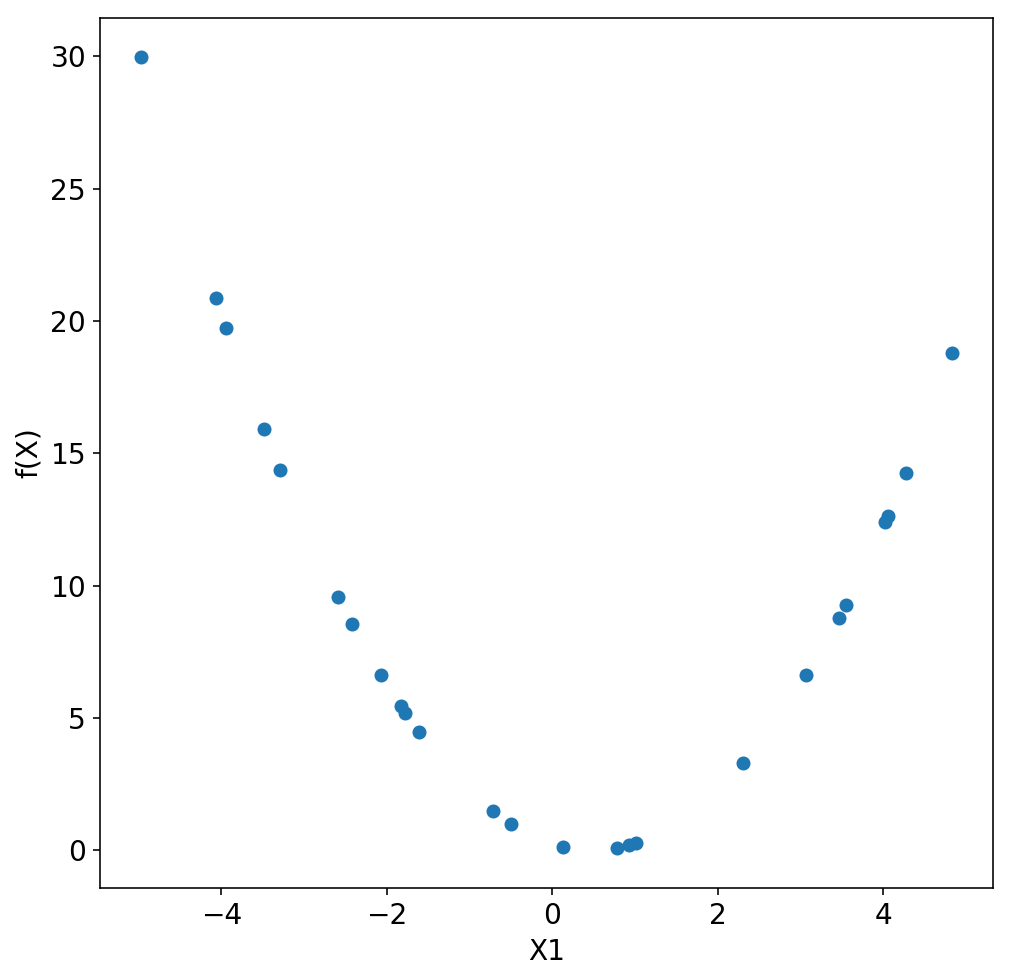

In [14]:
vals = []
for n in range(25):
    x1 = np.random.uniform(-5, 5)
    x2 = np.random.uniform(-5, 5)
    vals.append((x1, x2, f((x1, x2))))
vals = np.array(vals)
        
plt.plot(vals[:, 0], vals[:, 2], 'o')
plt.xlabel("X1")
plt.ylabel("f(X)");

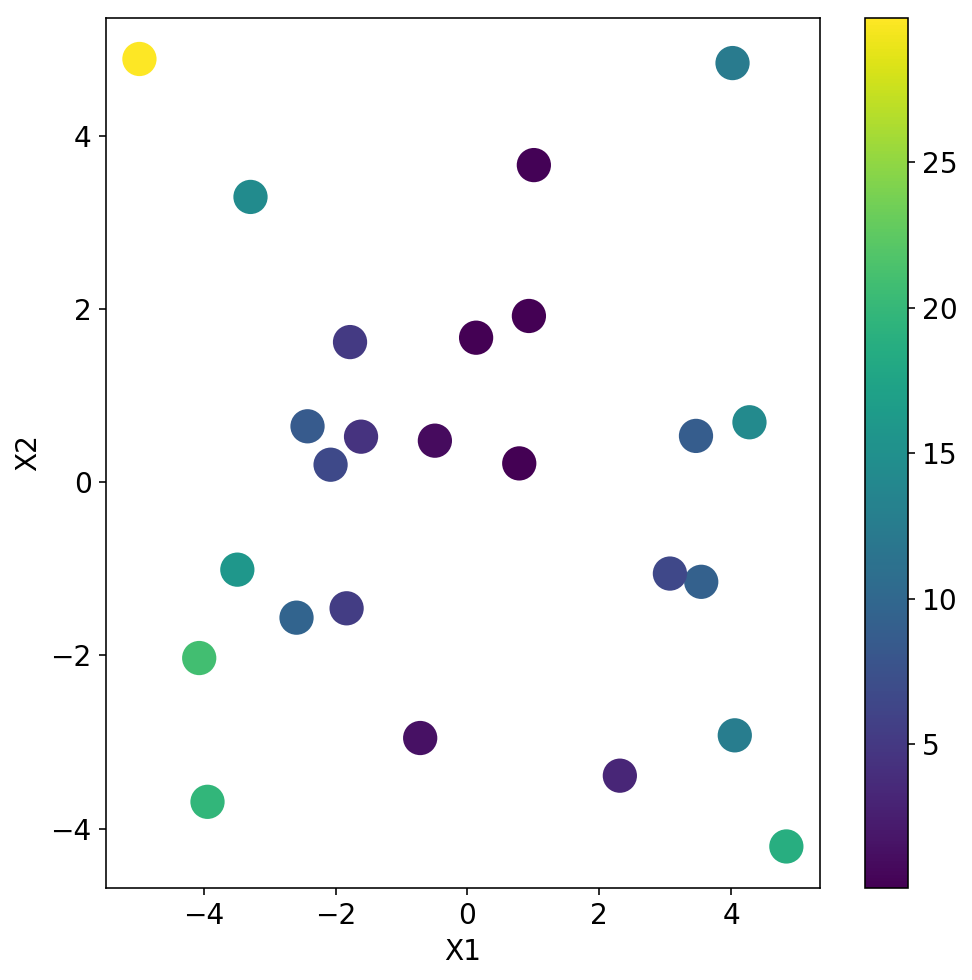

In [15]:
plt.scatter(vals[:, 0], vals[:, 1], c=vals[:, 2], s=260)
plt.colorbar()
plt.xlabel("X1")
plt.ylabel("X2");